***Imports***

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import gym
import glob
import io
import time
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from IPython.display import clear_output

***Environment***

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

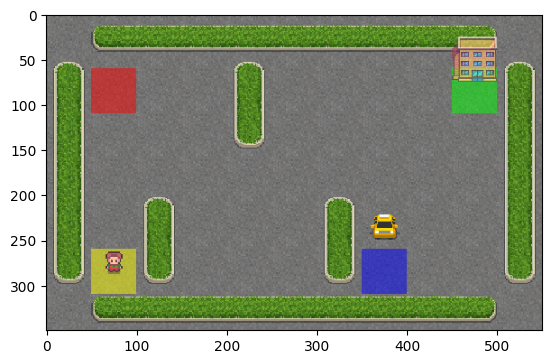

369
passenger is at yellow and destination is at green and taxi is at 3,3.


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


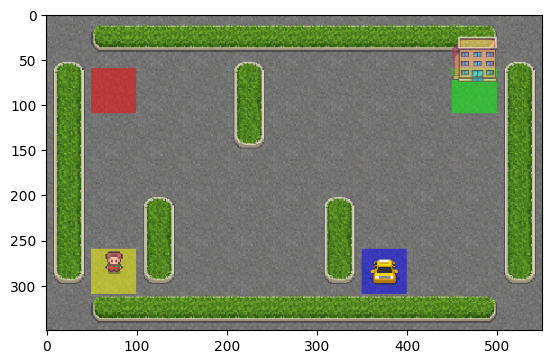

In [2]:
'''
importing taxi as environment
'''

env=gym.make('Taxi-v3')
state=env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(state)

def give_positions(state):
  passenger=(state//4)%5
  destination = state%4
  taxi_col=(state//20)%5
  taxi_row=state//100
  return passenger,destination,taxi_row,taxi_col

passenger_location,destination_location,taxi_r,taxi_c=give_positions(state)

locations=['red','green','yellow','blue']

print('passenger is at {} and destination is at {} and taxi is at {},{}.'.format(locations[passenger_location],locations[destination_location],taxi_r,taxi_c))

next_state,reward,done,_=env.step(0)
plt.imshow(env.render(mode="rgb_array"))
plt.show()

***Softmax***

In [3]:
def softmax(Q_values,tau):
  Q_values /= tau
  exp_vals = np.exp(Q_values - np.max(Q_values))
  exp_vals /= np.sum(exp_vals)
  return np.argmax(exp_vals)

***Epsilon_greedy***

In [4]:
def epsilon_greedy(Q_values,eps):
  if np.random.rand() > eps:
    return np.argmax(Q_values)
  else :
    return np.random.choice(np.arange(0,len(Q_values)))

***SMDPQ_learning***

In [5]:
gamma=0.9
episodes=2500
option_values={'red':(0,0),'green':(0,4),'yellow':(4,0),'blue':(4,3)}
option_action_table={}
option_action_table['red']=[[0,3,0,0,0],
                            [1,3,3,3,3],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['green']=[[0,0,2,2,0],
                            [2,2,2,2,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['yellow']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [0,3,3,3,3],
                            [0,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['blue']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [2,2,2,0,3],
                            [1,1,1,0,1],
                            [1,1,1,1,1]]



def SMDPQ_learning(option_action_table,env,tau,alpha):
  Q_values=np.zeros((500,10))
  final_reward=np.zeros(episodes)

  for episode in range(episodes):
    episode_reward=0
    state=env.reset()

    passenger,destination,_,_=give_positions(state)
    while passenger==destination :                             # to get a case where start and end are not same
      state=env.reset()
      passenger,destination,_,_=give_positions(state)


    done=False
    while not done :
      action = softmax(Q_values[state],tau)
      # action = epsilon_greedy(Q_values[state],tau)

      if action < 6 :
        next_state,reward,epi_done,_=env.step(action)
        Q_values[state][action]+=alpha*(reward+gamma*np.max(Q_values[next_state])-Q_values[state][action])
        episode_reward+=reward
        state=next_state
        if reward==20 or epi_done:
          done=True

      else :
        opt_reward=0
        begin=state
        cnt=0
        while True:
          _,_,taxi_row,taxi_col=give_positions(state)
          next_state,reward,opt_done,_=env.step(option_action_table[locations[action-6]][taxi_row][taxi_col])
          episode_reward+=reward
          opt_reward+=(gamma**cnt)*reward
          if opt_done or reward==20:
            done = True
            break
          _,_,taxi_row,taxi_col=give_positions(next_state)
          if (taxi_row,taxi_col) == option_values[locations[action-6]] :
            break
          state=next_state
          cnt+=1
        Q_values[begin][action]+=alpha*(opt_reward+(gamma**cnt)*np.max(Q_values[state])-Q_values[begin][action])
    final_reward[episode]=episode_reward
  return final_reward,Q_values

***Fine tuning***

In [6]:
alphaList = [0.1,0.3,0.5,0.7,0.9]
tauList = [0.1,0.5,0.7,1,2.5]
rewardList=[]
for alpha in alphaList:
  for tau in tauList:
    ret_r,_=SMDPQ_learning(option_action_table,env,tau,alpha)
    rewardList.append(np.average(ret_r))

print('the rewards for all the permutaions of hyperparameters are as follows')
print(rewardList)

ind=np.argmax(np.array(rewardList))
best_alpha=alphaList[ind//5]
best_tau=tauList[ind%5]
best_avg_reward=rewardList[ind]
print(f'Basing on rewards, best hyperparameters are {best_alpha} as alpha and {best_tau} as tau with average reward as {best_avg_reward}.')

<ipython-input-3-365e7ee6a906>:2: RuntimeWarning: overflow encountered in divide
  Q_values /= tau
<ipython-input-3-365e7ee6a906>:3: RuntimeWarning: invalid value encountered in subtract
  exp_vals = np.exp(Q_values - np.max(Q_values))
<ipython-input-5-fac6ddd2fbd6>:49: RuntimeWarning: invalid value encountered in scalar add
  Q_values[state][action]+=alpha*(reward+gamma*np.max(Q_values[next_state])-Q_values[state][action])
<ipython-input-5-fac6ddd2fbd6>:49: RuntimeWarning: invalid value encountered in scalar subtract
  Q_values[state][action]+=alpha*(reward+gamma*np.max(Q_values[next_state])-Q_values[state][action])


the rewards for all the permutaions of hyperparameters are as follows
[-202.052, -202.1888, -199.716, -94.264, -210.0944, -202.088, -199.5792, -201.6232, -51.0208, -206.9332, -202.0556, -199.9544, -202.0512, -34.9152, -202.5428, -202.0592, -202.1456, -200.9236, -32.404, -192.2884, -202.0844, -202.1672, -200.3984, -31.9492, -179.1488]
Basing on rewards, best hyperparameters are 0.9 as alpha and 1 as tau with average reward as -31.9492.


***Plots***

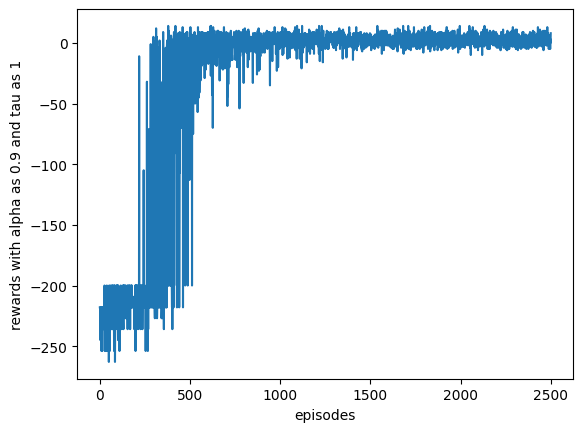

In [7]:
# best_tau=1
# best_alpha=0.9
final_reward,Q_values=SMDPQ_learning(option_action_table,env,best_tau,best_alpha)
plt.figure()
plt.xlabel('episodes')
plt.ylabel(f'rewards with alpha as {best_alpha} and tau as {best_tau}')
plt.plot(final_reward)